In [47]:
using Revise
using Bilevel

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using Plots
using LinearAlgebra
using StaticArrays
using BenchmarkTools

gr(size=(800,500),html_output_format=:png,
    seriescolor=:magma,background_color_legend=:white,
    background=RGB(((240,240,240) ./ 255.)...));

# Contact

## Single point with contact

In [56]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles)

Environment(Contact[Contact(Spanning tree:
Vertex: world (root)
  Vertex: floor, Edge: floor_to_world
    Vertex: ball, Edge: floor_to_ball
No non-tree joints., ball, Point3D in "after_floor_to_ball": [0.0, 0.0, 0.0], Obstacle(floor, Point3D in "after_floor_to_world": [0.0, 0.0, 0.0], FreeVector3D in "after_floor_to_world": [0.0, 0.0, 1.0], [1.0 6.12323e-17 -1.0 -1.83697e-16; 0.0 1.0 1.22465e-16 -1.0; 0.0 0.0 0.0 0.0], 1.0, false))])

In [3]:
N = 10
Δt = 0.1
q0 = [1., 0., 0., 0., 0., 0., 0.]
v0 = [0., 0., 0., 5., 0., 0.] 

sim_data = get_sim_data_indirect(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
traj = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

(Array{Float64,1}[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, -6.657e-17, -8.88178e-17, 0.4019, 0.0, 3.46945e-18], [1.0, 0.0, -6.66134e-17, -8.88178e-17, 0.7057, 0.0, 3.46945e-18], [1.0, 0.0, -6.66134e-17, -8.88178e-17, 0.9114, 0.0, 3.46945e-18], [1.0, 0.0, -6.66134e-17, -8.88178e-17, 1.019, 0.0, 3.46945e-18], [1.0, 0.0, -6.66134e-17, -8.88178e-17, 1.0285, 0.0, 3.46945e-18], [1.0, 0.0, -6.66134e-17, 0.0, 1.0285, -2.9976e-19, 3.46945e-18], [1.0, 0.0, -6.66134e-17, 0.0, 1.0285, 1.45403e-26, 3.46945e-18], [1.0, 0.0, -6.66134e-17, 0.0, 1.0285, 1.45403e-26, 3.46945e-18], [1.0, 0.0, -6.66134e-17, 0.0, 1.0285, 1.45403e-26, 3.46945e-18]], Array{Float64,1}[[0.0, 0.0, 0.0, 5.0, 0.0, 0.0], [0.0, -1.33227e-15, 0.0, 4.019, 0.0, -5.00397e-16], [0.0, -1.33227e-15, 0.0, 3.038, 0.0, -4.74216e-16], [0.0, -1.33227e-15, 0.0, 2.057, 0.0, -2.39269e-16], [0.0, -1.33227e-15, 0.0, 1.076, 0.0, -2.12825e-16], [0.0, -1.33227e-15, 0.0, 0.095, 0.0, 2.21217e-17], [0.0, -1.33227e-15, 0.0, -1.00166e-25, -2.9976e-1

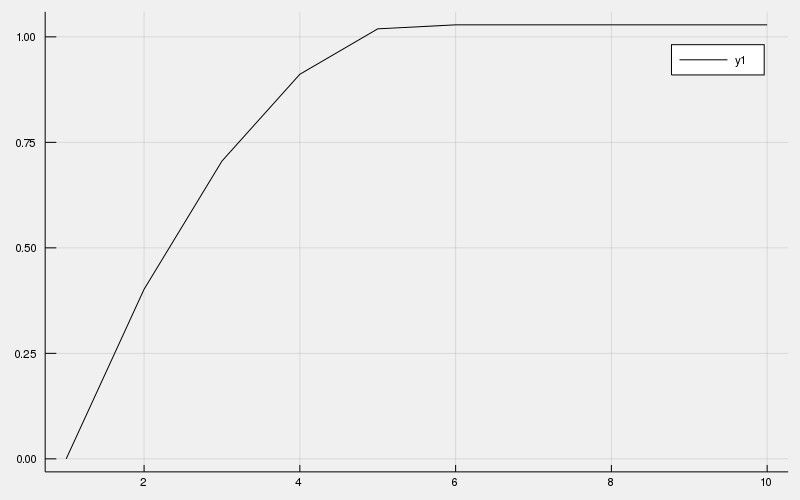

In [4]:
plot(traj[7][5,:])

In [57]:
q1 = [1., 0., 0., 0., 0., 0., 0.]
qN = [1., 0., 0., 0., 1., 0., 0.]
N = 10
Δt = .1

q_min = [-1., -1., -1., -1., -5., -5., -5.]
q_max = [1., 1., 1., 1., 5., 5., 5.]

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    # torques limits
    add_box_con_snopt!(x_min, x_max, sim_data, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)

    x_min, x_max
end

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, length(q1), x -> vs(x, :q1) - q1)
    add_eq!(sim_data, :cqN, length(qN), x -> vs(x, Symbol("q", N)) - qN)
    add_eq!(sim_data, :cv1, 1, x -> vs(x, :v1)[6])
    add_eq!(sim_data, :cvN, 1, x -> vs(x, Symbol("v", N))[4])
end

add_prob_constraints! (generic function with 1 method)

In [91]:
sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
traj_indirect = Bilevel.trajopt(sim_data, x_min=x_min, x_max=x_max, quaternion_state=true, verbose=1)

The problem appears to be infeasible: nonlinear infeasibilities minimized


(Array{Float64,1}[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 4.40757e-15, -8.40906e-15, 8.85044e-15, 0.3962, 1.65727e-15, 1.39136e-9], [1.0, -1.7245e-16, -1.68642e-14, 1.83072e-14, 0.7924, 1.45597e-14, -0.0981], [1.0, 9.56156e-15, -2.00802e-14, 4.10636e-15, 0.8943, 1.78695e-14, -4.92519e-15], [1.0, 1.69078e-14, -8.8926e-15, -1.18784e-14, 0.9962, 1.32273e-14, 0.0], [1.0, 2.2134e-14, -8.98806e-15, -2.80244e-14, 1.0, 5.25467e-15, -6.46235e-27], [1.0, 1.59139e-14, 5.26646e-15, -2.08356e-14, 1.0, 1.19174e-14, -3.90157e-14], [1.0, 8.48866e-15, 2.79536e-16, -1.35926e-14, 1.0, -4.20053e-25, 0.0], [1.0, 4.2737e-15, 1.84398e-16, -6.79631e-15, 1.0, -2.0001e-24, 0.0], [1.0, 0.0, 7.32289e-22, 0.0, 1.0, 0.0, 0.0]], Array{Float64,1}[[-7.83184e-14, -1.68181e-13, 1.35926e-13, 4.943, 6.64981e-14, 0.0], [-7.83184e-14, -1.68181e-13, 1.35926e-13, 3.962, 3.0132e-14, 1.39136e-8], [-7.83184e-14, -1.69069e-13, 1.35926e-13, 3.962, -1.57005e-14, -0.981], [-7.83183e-14, -1.70706e-13, 1.35926e-13, 1.019, 2.48117e-

In [89]:
sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
traj_semidirect = Bilevel.trajopt(sim_data, x_min=x_min, x_max=x_max, quaternion_state=true, verbose=1)

Terminated after numerical difficulties: current point cannot be improved


(Array{Float64,1}[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.998731, 0.0, 0.0503603, 9.19249e-28, 0.463764, 0.0, 0.0], [0.994936, 0.0, 0.100508, 1.83738e-27, 0.818801, 2.58494e-26, 0.0], [0.986776, 1.23771e-26, 0.16209, 4.12571e-27, 1.03144, 2.58494e-26, 0.0], [0.977613, 4.11324e-27, 0.210412, 4.11324e-27, 1.13686, 2.58494e-26, 0.0], [0.96619, 8.19328e-27, 0.257831, 4.09664e-27, 1.13912, 1.29247e-26, 0.0], [0.95262, -8.15229e-27, 0.304164, 8.15229e-27, 1.09179, 6.46235e-27, 5.21937e-19], [0.957778, -8.13686e-27, 0.287507, 1.62737e-26, 1.03656, 6.46235e-27, 0.0096855], [0.983202, -3.87388e-27, 0.182522, -9.6847e-28, 0.998312, 3.23117e-27, 0.0164138], [0.999576, 0.0, -0.0291063, 0.0, 0.998046, 0.0, -1.25665e-11]], Array{Float64,1}[[5.16988e-26, 1.09332, 2.58494e-26, 7.61273, 5.16988e-26, 0.0], [5.16988e-26, 1.09332, 2.58494e-26, 6.12061, 0.0, 0.559593], [5.16988e-26, 1.09332, 2.58494e-26, 4.58897, 0.0, 0.87549], [5.16988e-26, 1.09332, 2.58494e-26, 3.3267, -2.58494e-26, 1.1115], [5.16988e-26

In [90]:
sim_data = get_trajopt_data_direct(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
traj_direct = Bilevel.trajopt(sim_data, x_min=x_min, x_max=x_max, quaternion_state=true, verbose=1)

The problem appears to be infeasible: nonlinear infeasibilities minimized


(Array{Float64,1}[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], Array{Float64,1}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], Array{Float64,1}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 

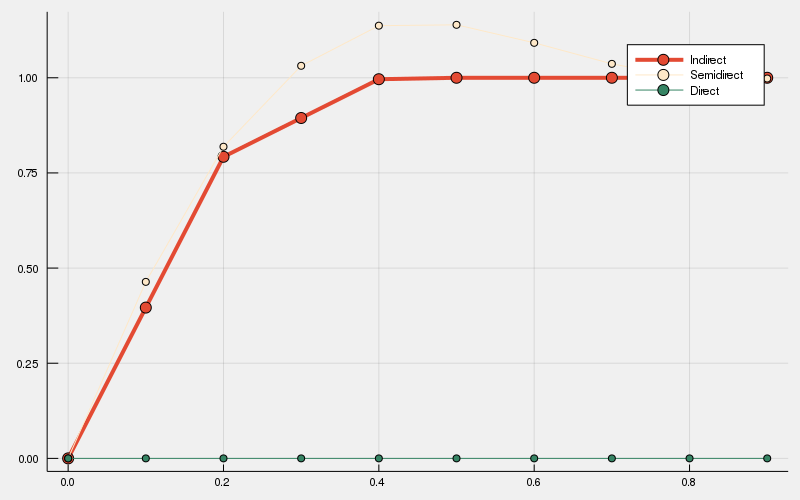

In [92]:
j = 5
plot(traj_indirect[7],traj_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=4,marker=6)
plot!(traj_semidirect[7],traj_semidirect[8][j,:],label="Semidirect",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=0,marker=4)
plot!(traj_direct[7],traj_direct[8][j,:],label="Direct",seriescolor=RGB(((54,132,100) ./ 255.)...),linewidth=0,marker=4)

# Box with four contact

In [2]:
μ_floor = .1

urdf = joinpath("..", "urdf", "box.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, μ_floor)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [3]:
Δt = 0.1
N = 10

x0 = MechanismState(mechanism)
set_configuration!(x0,[1.,0.,0.,0.,0.,0.,0.25])
set_velocity!(x0,[0.,0.,0.,.75,0.,0.])
setdirty!(x0)

sim_data = get_sim_data_indirect(mechanism,env,Δt)

null_ctrl! = (u,t,x) -> u[:] .= 0.
traj_sim = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

(Array{Float64,1}[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25], [1.0, -2.33856e-13, 5.77351e-12, 1.73835e-13, 0.06519, 1.11892e-14, 0.25], [1.0, 2.33868e-13, -4.42214e-17, 3.40924e-14, 0.12057, 2.82264e-14, 0.25], [1.0, -2.33862e-13, -2.70737e-17, 1.1731e-15, 0.16614, 4.10496e-15, 0.25], [1.0, 2.33916e-13, 1.37703e-16, 4.79904e-14, 0.2019, 2.57306e-15, 0.25], [1.0, -2.33902e-13, -1.53131e-16, 4.72812e-17, 0.22785, 9.67919e-16, 0.25], [1.0, 2.33855e-13, 1.7963e-16, 4.68298e-14, 0.24399, 2.78226e-15, 0.25], [1.0, -2.33881e-13, -1.16755e-16, 1.03662e-17, 0.25032, 9.22335e-16, 0.25], [1.0, 2.33893e-13, -1.78179e-10, -9.15414e-11, 0.25032, 4.56538e-11, 0.25], [1.0, -2.47553e-13, -1.07933e-11, -1.30653e-10, 0.25032, 6.53204e-11, 0.25]], Array{Float64,1}[[0.0, 0.0, 0.0, 0.75, 0.0, 0.0], [-4.67711e-12, 1.1547e-10, -2.73483e-13, 0.6519, 5.16445e-14, 3.63716e-11], [4.67737e-12, -1.15471e-10, 9.55331e-13, 0.5538, -6.37027e-15, -3.04109e-11], [-4.67725e-12, -5.41473e-16, 2.3462e-14, 0.4557, 1.50488e-14, 3

In [47]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)

┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8700
└ @ MeshCat /Users/blandry/.julia/packages/MeshCat/WlA0B/src/servers.jl:24


Process(`open http://127.0.0.1:8700`, ProcessExited(0))

In [48]:
setanimation!(mvis, traj_sim[6], traj_sim[1])

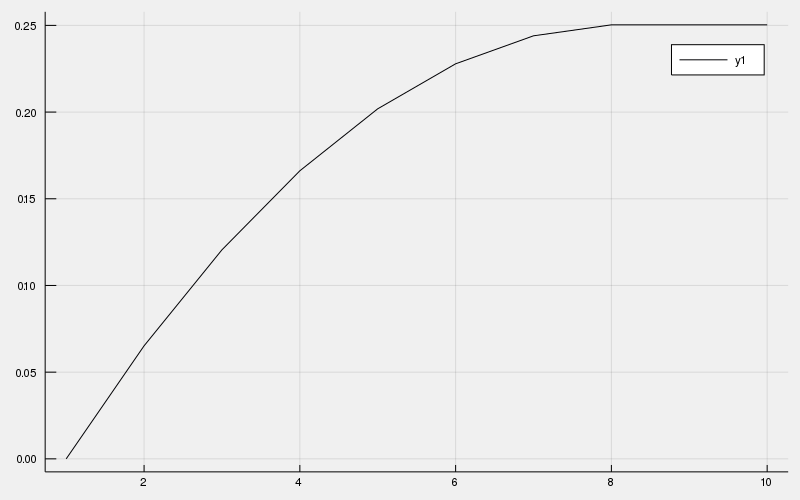

In [4]:
plot(traj_sim[7][5,:])

In [5]:
q1 = [1., 0., 0., 0., 0., 0., 0.25]
qN = [1., 0., 0., 0., .25, 0., 0.25]
N = 10
Δt = 0.1

q_min = [-1., -1., -1., -1., -5., -5., -5.]
q_max = [1., 1., 1., 1., 5., 5., 5.]

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    # torques limits
    add_box_con_snopt!(x_min, x_max, sim_data, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)

    x_min, x_max
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
       x0[sim_data.vs(Symbol("q", n))] = n/N * (qN - q1) + q1 
    end
end

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, length(q1), x -> vs(x, :q1) - q1)
    add_eq!(sim_data, :cqN, length(qN), x -> vs(x, Symbol("q", N)) - qN)
    add_eq!(sim_data, :cv1, 1, x -> vs(x, :v1)[6])
    add_eq!(sim_data, :cvN, 1, x -> vs(x, Symbol("v", N))[4])
end

add_prob_constraints! (generic function with 1 method)

# 2D box

In [90]:
urdf = joinpath("..", "urdf", "box2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.125)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles)

Environment(Contact[Contact(Spanning tree:
Vertex: world (root)
  Vertex: floor, Edge: floor_to_world
    Vertex: box, Edge: floor_to_box
No non-tree joints., box, Point3D in "after_floor_to_box": [-0.06, 0.0, -0.0375], Obstacle(floor, Point3D in "after_floor_to_world": [0.0, 0.0, 0.0], FreeVector3D in "after_floor_to_world": [0.0, 0.0, 1.0], [1.0 6.12323e-17 -1.0 -1.83697e-16; 0.0 1.0 1.22465e-16 -1.0; 0.0 0.0 0.0 0.0], 1.125, false)), Contact(Spanning tree:
Vertex: world (root)
  Vertex: floor, Edge: floor_to_world
    Vertex: box, Edge: floor_to_box
No non-tree joints., box, Point3D in "after_floor_to_box": [0.06, 0.0, -0.0375], Obstacle(floor, Point3D in "after_floor_to_world": [0.0, 0.0, 0.0], FreeVector3D in "after_floor_to_world": [0.0, 0.0, 1.0], [1.0 6.12323e-17 -1.0 -1.83697e-16; 0.0 1.0 1.22465e-16 -1.0; 0.0 0.0 0.0 0.0], 1.125, false))])

In [91]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)

Could not open browser automatically: ErrorException("failed process: Process(`xdg-open http://127.0.0.1:8702`, ProcessExited(3)) [3]")
Please open the following URL in your browser:
http://127.0.0.1:8702


┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8702
└ @ MeshCat /home/blandry/.julia/packages/MeshCat/WlA0B/src/servers.jl:24
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'http://127.0.0.1:8702'
Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")
Stacktrace:
 [1] try_yieldto(::typeof(Base.ensure_rescheduled), ::Base.RefValue{Task}) at ./event.jl:196
 [2] wait() at ./event.jl:255
 [3] wait(::Condition) at ./event.jl:46
 [4] wait(::Task) at ./task.jl:188
 [5] create_socket(::Dict{Any,Any}) at /home/blandry/.julia/packages/WebIO/Rk8wc/src/providers/mux.jl:4

In [116]:
q1 = [0., -0.0375, 0.]
qN = [1., -0.0375, 0.]
N = 20
Δt = .05

q_min = [-5., -5., -2*pi]
q_max = [5., 5., 2*pi]

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [.9*Δt], [1.1*Δt], 1:N-1)
    
    # torques limits
    add_box_con_snopt!(x_min, x_max, sim_data, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)

    x_min, x_max
end

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, length(q1), x -> vs(x, :q1) - q1)
    add_eq!(sim_data, :cv1, 1, x -> vs(x, :v1)[2])
    add_eq!(sim_data, :cqN, 1, x -> vs(x, Symbol("q", N))[1] - qN[1])
    add_eq!(sim_data, :cvN, 1, x -> vs(x, Symbol("v", N))[1])
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        x0[sim_data.vs(Symbol("q", n))] .= n/N*(qN - q1) + q1
    end
    
    x0
end

get_prob_init (generic function with 1 method)

In [97]:
sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)
traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, quaternion_state=true, verbose=1)

The problem appears to be infeasible: nonlinear infeasibilities minimized


(Array{Float64,1}[[-4.33681e-19, -0.0385, 0.0], [0.247919, -0.0455649, 0.141094], [0.453316, -0.0526748, 0.28114], [0.58485, -0.0652872, 0.394818], [0.717778, -0.0619673, 0.508497], [0.809243, -0.0654135, 0.621145], [0.875671, -0.068018, 0.733151], [0.917293, -0.0697625, 0.844518], [0.934317, -0.0706401, 0.955246], [0.942042, -0.0706579, 1.06457], [0.949547, -0.0698532, 1.17202], [0.956756, -0.0682776, 1.27759], [0.963599, -0.0659897, 1.3813], [0.97002, -0.0630531, 1.48312], [0.97597, -0.0595353, 1.58307], [0.981413, -0.0555062, 1.68113], [0.986321, -0.0510366, 1.77729], [0.990642, -0.0540619, 1.87074], [0.996785, -0.0373797, 1.96418], [1.0, -0.0356918, 2.05426]], Array{Float64,1}[[5.4838, 0.0, 2.58895], [4.44476, -0.761065, 2.56534], [3.55201, -1.16034, 2.5463], [2.5903, -1.38301, 2.52618], [2.6575, -1.29952, 2.52618], [1.60832, -1.24515, 2.50329], [1.05817, -1.03089, 2.48903], [0.585258, -0.717274, 2.47481], [0.202517, -0.320137, 2.46063], [0.0828873, -0.150315, 2.42935], [0.0812438,

In [50]:
@benchmark traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, quaternion_state=true, verbose=0)

BenchmarkTools.Trial: 
  memory estimate:  23.56 MiB
  allocs estimate:  233739
  --------------
  minimum time:     19.921 ms (0.00% GC)
  median time:      21.003 ms (0.00% GC)
  mean time:        21.147 ms (0.00% GC)
  maximum time:     36.708 ms (0.00% GC)
  --------------
  samples:          237
  evals/sample:     1

In [98]:
setanimation!(mvis, traj_indirect[7], traj_indirect[1])

In [117]:
sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)
traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, quaternion_state=true, verbose=1)

Terminated after numerical difficulties: cannot satisfy the general constraints



Error thrown in threaded loop on thread 11: LinearAlgebra.LAPACKException(info=13)
Error thrown in threaded loop on thread 11: LinearAlgebra.LAPACKException(info=13)
Error thrown in threaded loop on thread 11: LinearAlgebra.LAPACKException(info=13)
Error thrown in threaded loop on thread 11: LinearAlgebra.LAPACKException(info=13)
Error thrown in threaded loop on thread 11: LinearAlgebra.LAPACKException(info=13)
Error thrown in threaded loop on thread 11: LinearAlgebra.LAPACKException(info=13)
Error thrown in threaded loop on thread 11: LinearAlgebra.LAPACKException(info=13)
Error thrown in threaded loop on thread 11: LinearAlgebra.LAPACKException(info=13)
Error thrown in threaded loop on thread 11: LinearAlgebra.LAPACKException(info=13)
Error thrown in threaded loop on thread 11: LinearAlgebra.LAPACKException(info=13)
Error thrown in threaded loop on thread 11: LinearAlgebra.LAPACKException(info=13)
Error thrown in threaded loop on thread 11: LinearAlgebra.LAPACKException(info=13)
Err

(Array{Float64,1}[[0.0, -0.0375, 0.0], [0.18032, -0.0391109, -0.0270769], [0.331785, -0.0404423, -0.0498154], [0.454206, -0.0415036, -0.0681895], [0.547317, -0.0423029, -0.0821678], [0.610886, -0.0428461, -0.0917219], [0.644687, -0.043137, -0.0968232], [0.648513, -0.0431771, -0.0974447], [0.627722, -0.0429656, -0.0935596], [0.601148, -0.0425689, -0.0863949], [0.592153, -0.0420705, -0.0775306], [0.615963, -0.041613, -0.0696333], [0.665686, -0.0411604, -0.0619319], [0.720129, -0.0406171, -0.0526143], [0.780149, -0.0399968, -0.0419999], [0.850803, -0.0393043, -0.03023], [0.925521, -0.0385096, -0.0168105], [0.975131, -0.0391594, 0.00226215], [1.0, -0.0397407, 0.0230145], [1.0, -0.0403543, 0.046657]], Array{Float64,1}[[4.04399, 0.0, -0.606185], [3.45293, 0.0596349, -0.517446], [2.89835, 0.112916, -0.434294], [2.34054, 0.130355, -0.350636], [1.77877, 0.118743, -0.266378], [1.21391, 0.0852845, -0.181568], [0.645796, 0.0372859, -0.0962111], [0.0741709, -0.0177348, -0.010331], [-0.372098, -0.05

In [53]:
@benchmark traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, quaternion_state=true, verbose=0)

BenchmarkTools.Trial: 
  memory estimate:  248.90 MiB
  allocs estimate:  1970789
  --------------
  minimum time:     142.546 ms (0.00% GC)
  median time:      144.848 ms (0.00% GC)
  mean time:        158.715 ms (0.00% GC)
  maximum time:     313.000 ms (0.00% GC)
  --------------
  samples:          32
  evals/sample:     1

In [89]:
setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

In [105]:
sim_data = get_trajopt_data_direct(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)
traj_direct = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, quaternion_state=true, verbose=1)

Terminated after numerical difficulties: current point cannot be improved


(Array{Float64,1}[[0.0, -0.0385, 0.0], [0.0319348, -0.0532252, -0.0102206], [0.0700899, -0.0795139, -0.0202576], [0.113994, -0.111735, -0.0298108], [0.161359, -0.141582, -0.035691], [0.210323, -0.16105, -0.0407552], [0.26, -0.165817, -0.0453024], [0.309747, -0.151206, -0.0497327], [0.36033, -0.116431, -0.054158], [0.411769, -0.0616577, -0.0585655], [0.463947, 0.0124977, -0.0630223], [0.51692, 0.105169, -0.0677303], [0.570948, 0.217657, -0.072415], [0.626346, 0.350957, -0.0770769], [0.683635, 0.507852, -0.0817163], [0.742776, 0.683251, -0.0863338], [0.804103, 0.876463, -0.0909301], [0.867306, 1.08224, -0.0954973], [0.932588, 1.2937, -0.100053], [1.0, 1.53746, -0.104584]], Array{Float64,1}[[0.570848, 0.0, -0.157107], [0.720495, -0.319109, -0.15757], [0.868473, -0.55913, -0.153499], [0.996964, -0.663649, -0.144382], [1.07634, -0.597174, -0.132298], [1.10308, -0.352477, -0.114355], [1.09543, -0.0146227, -0.102982], [1.05399, 0.423448, -0.100412], [1.01503, 0.878832, -0.100301], [0.964513, 

In [106]:
@benchmark traj_direct = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, quaternion_state=true, verbose=0)

BenchmarkTools.Trial: 
  memory estimate:  1.11 GiB
  allocs estimate:  6359059
  --------------
  minimum time:     697.288 ms (0.00% GC)
  median time:      1.013 s (0.00% GC)
  mean time:        2.625 s (40.13% GC)
  maximum time:     9.262 s (56.86% GC)
  --------------
  samples:          5
  evals/sample:     1

In [75]:
setanimation!(mvis, traj_direct[7], traj_direct[1])

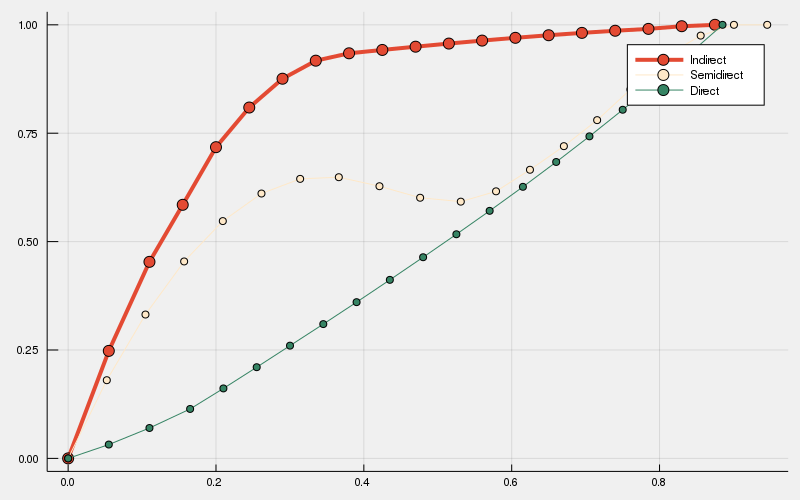

Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")
Stacktrace:
 [1] try_yieldto(::typeof(Base.ensure_rescheduled), ::Base.RefValue{Task}) at ./event.jl:196
 [2] wait() at ./event.jl:255
 [3] wait(::Condition) at ./event.jl:46
 [4] wait(::Task) at ./task.jl:188
 [5] create_socket(::Dict{Any,Any}) at /home/blandry/.julia/packages/WebIO/Rk8wc/src/providers/mux.jl:44
 [6] (::getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(WebIO.create_socket)})(::Function, ::Dict{Any,Any}) at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:17
 [7] #1 at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:10 [inlined]
 [8] splitquery(::getfield(Mux, Symbol("##1#2")){getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(WebIO.create_socket)},getfield(Mux, Symbol("##1#2")){typeof(Mux.wclose),getfield(Mux, Symbol("##1#2")){getfield(Mux, Symbol(

In [118]:
j = 1
plot(traj_indirect[7],traj_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=4,marker=6)
plot!(traj_semidirect[7],traj_semidirect[8][j,:],label="Semidirect",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=0,marker=4)
plot!(traj_direct[7],traj_direct[8][j,:],label="Direct",seriescolor=RGB(((54,132,100) ./ 255.)...),linewidth=0,marker=4)

## Little dog

In [2]:
urdf = joinpath("..", "urdf", "little_dog", "little_dog_2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
N = 10
Δt = 0.1
q0 = [0., -.175, 0., 0., 0., 0., 0., .036, 0., 0., 0., .00758, 0., .002445, 0.]  
v0 = zeros(num_velocities(mechanism))

sim_data = get_sim_data_indirect(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
traj = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [3]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));
# open(mvis)
IJuliaCell(mvis)

WebIO.Scope("scope-880fa889-9a4a-4652-a9b7-ebec90887a7d", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :iframe), Any[], Dict{Symbol,Any}(:attributes=>Dict{String,Any}("height"=>"100%","scrolling"=>"no","src"=>"javascript:void(0)","frameborder"=>0),:id=>"ifr",:style=>Dict("width"=>"100%","flexGrow"=>"1")), 0)], Dict{Symbol,Any}(:style=>Dict("flexDirection"=>"column","height"=>"100%","minHeight"=>"400px","display"=>"flex","width"=>"100%","overflow"=>"hidden")), 1), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}(), Set(String[]), nothing, Any[], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function () {\n    var frame = this.dom.querySelector(\"#ifr\");\n    var doc = frame.contentDocument\n    var win = frame.contentWindow\n\n    // Ensure that the iframe's baseURI matches the baseURI of the\n    // outer document. This is necessary to resolve\n    // https://github.com/JuliaGizmos/WebIO.jl/issues/167\n    var base = doc.createElement(\"base\");\n    base.setAttribute(\"href\", document.baseURI);\n    doc.head.appendChild(base);\n\n    var webio = doc.createElement(\"script\")\n    webio.src = \"/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/webio/dist/bundle.js\"\n    var parent = window\n\n    function resizeIframe() {\n        doc.body.style.padding = '0'\n        doc.body.style.margin = '0'\n        doc.documentElement.height = '100%'\n        doc.body.height = '100%'\n    }\n\n    webio.onload = function () {\n        win.WebIO.sendCallback = parent.WebIO.sendCallback; // Share stuff\n        win.WebIO.scopes = parent.WebIO.scopes\n        win.WebIO.obsscopes = parent.WebIO.obsscopes\n        win.WebIO._connected = true\n        doc.body.innerHTML = \"<html><body>\" + \"<div class='display:none'></div><unsafe-script style='display:none'>\\nWebIO.mount(this.previousSibling,{&quot;props&quot;:{},&quot;nodeType&quot;:&quot;Scope&quot;,&quot;type&quot;:&quot;node&quot;,&quot;instanceArgs&quot;:{&quot;imports&quot;:{&quot;data&quot;:[{&quot;name&quot;:null,&quot;type&quot;:&quot;js&quot;,&quot;url&quot;:&quot;/assetserver/cff5eb7af79db7e6d407febf164549a9fdb258cd-main.min.js&quot;}],&quot;type&quot;:&quot;async_block&quot;},&quot;id&quot;:&quot;scope-e0bd907a-fad0-4bb9-a0ee-67e52fad0281&quot;,&quot;handlers&quot;:{&quot;meshcat-command&quot;:[(function (val){return this.viewer.handle_command_message({&quot;data&quot;:val})})],&quot;_promises&quot;:{&quot;importsLoaded&quot;:[(function (mc){var element=this.dom.children[0]; this.viewer=new mc.Viewer(element); WebIO.setval({&quot;name&quot;:&quot;meshcat-request&quot;,&quot;scope&quot;:&quot;scope-e0bd907a-fad0-4bb9-a0ee-67e52fad0281&quot;,&quot;id&quot;:&quot;ob_02&quot;,&quot;type&quot;:&quot;observable&quot;},String(Date.now())); window.document.body.style.margin=&quot;0&quot;; return window.meshcat_viewer=this.viewer})]}},&quot;systemjs_options&quot;:null,&quot;observables&quot;:{&quot;meshcat-command&quot;:{&quot;sync&quot;:false,&quot;id&quot;:&quot;ob_01&quot;,&quot;value&quot;:[131,166,109,97,116,114,105,120,199,64,23,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,7,206,153,189,0,0,128,63,164,116,121,112,101,173,115,101,116,95,116,114,97,110,115,102,111,114,109,164,112,97,116,104,218,0,82,47,109,101,115,104,99,97,116,47,119,111,114,108,100,47,102,108,111,111,114,47,98,111,100,121,47,98,97,99,107,95,114,105,103,104,116,95,104,105,112,47,98,97,99,107,95,114,105,103,104,116,95,117,112,112,101,114,95,108,101,103,47,98,97,99,107,95,114,105,103,104,116,95,108,111,119,101,114,95,108,101,103]},&quot;meshcat-controls&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_03&quot;,&quot;value&quot;:[]},&quot;meshcat-request&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_02&quot;,&quot;value&quot;:&quot;&quot;}}},&quot;children&quot;:[{&quot;props&quot;:{&quot;className&quot;:&quot;meshcat-viewer&quot;,&quot;style&quo

In [ ]:
using Pkg
Pkg.status()

In [ ]:
setanimation!(mvis, traj[6], traj[1])

In [4]:
widget = manipulate!(mvis)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Observable{Any} with 1 listeners. Value:
nothing], Dict{Symbol,Any}(), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope("knockout-component-60477376-ae8e-431d-a853-b657c3577bb1", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["floor_to_body.q1"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:className=>"interact-flex-row-left"), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>629,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:className=>"interact-flex-row-center"), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")), 0)], Dict{Symbol,Any}(:className=>"interact-flex-row-right"), 1)], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget"), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"index"=>(Observable{Any} with 2 listeners. Value:
315, nothing)), Set(String[]), nothing, Any["knockout"=>"/home/blandry/.julia/packages/Knockout/JE2Yq/src/../assets/knockout.js", "knockout_punches"=>"/home/blandry/.julia/packages/Knockout/JE2Yq/src/../assets/knockout_punches.js", "/home/blandry/.julia/packages/InteractBase/R8JgH/src/../assets/style.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-3.14159\",\"-3.13159\",\"-3.12158\",\"-3.11158\",\"-3.10157\",\"-3.09157\",\"-3.08156\",\"-3.07156\",\"-3.06155\",\"-3.05155\",\"-3.04154\",\"-3.03154\",\"-3.02153\",\"-3.01153\",\"-3.00152\",\"-2.99152\",\"-2.98151\",\"-2.97151\",\"-2.9615\",\"-2.9515\",\"-2.94149\",\"-2.93149\",\"-2.92148\",\"-2.91148\",\"-2.90147\",\"-2.89147\",\"-2.88146\",\"-2.87146\",\"-2.86145\",\"-2.85145\",\"-2.84144\",\"-2.83144\",\"-2.82143\",\"-2.81143\",\"-2.80142\",\"-2.79142\",\"-2.78141\",\"-2.7714\",\"-2.7614\",\"-2.75139\",\"-2.74139\",\"-2.73138\",\"-2.72138\",\"-2.71137\",\"-2.70137\",\"-2.69136\",\"-2.68136\",\"-2.67135\",\"-2.66135\",\"-2.65134\",\"-2.64134\",\"-2.63133\",\"-2.62133\",\"-2.61132\",\"-2.60132\",\"-2.59131\",\"-2.58131\",\"-2.5713\",\"-2.5613\",\"-2.55129\",\"-2.54129\",\"-2.53128\",\"-2.52128\",\"-2.51127\",\"-2.50127\",\"-2.49126\",\"-2.48126\",\"-2.47125\",\"-2.46125\",\"-2.45124\",\"-2.44124\",\"-2.43123\",\"-2.42123\",\"-2.41122\",\"-2.40122\",\"-2.39121\",\"-2.38121\",\"-2.3712\",\"-2.3612\",\"-2.35119\",\"-2.34119\",\"-2.33118\",\"-2.32118\",\"-2.31117\",\"-2.30117\",\"-2.29116\",\"-2.28116\",\"-2.27115\",

MethodError: no method matching size(::SArray{Tuple{3},Float64,1,3})
The applicable method may be too new: running in world age 25581, while current world is 25982.
Closest candidates are:
  size(::Union{Adjoint{T,#s15} where #s15<:Union{StaticArray{Tuple{#s12},T,1} where #s12, StaticArray{Tuple{#s13,#s14},T,2} where #s14 where #s13}, Diagonal{T,#s18} where #s18<:(StaticArray{Tuple{#s19},T,1} where #s19), Hermitian{T,#s17} where #s17<:(StaticArray{Tuple{T,M},T1,2} where T1 where M), Symmetric{T,#s16} where #s16<:(StaticArray{Tuple{T,M},T1,2} where T1 where M), Transpose{T,#s12} where #s12<:Union{StaticArray{Tuple{#s12},T,1} where #s12, StaticArray{Tuple{#s13,#s14},T,2} where #s14 where #s13}, StaticArray{Tuple{#s19},T,1} where #s19, StaticArray{Tuple{#s14,#s13},T,2} where #s13 where #s14, StaticArray{#s19,T,N} where N where #s19<:Tuple} where T) at /home/blandry/.julia/packages/StaticArrays/VyRz3/src/abstractarray.jl:9 (method too new to be called from this world context.)
  size(::Uni

In [ ]:
q_nom = [0., -.175, 0., 0., 0., 0., 0., .036, 0., 0., 0., .00758, 0., .002445, 0.] 
q_min = [-5., -.25, -2*pi, -.6, -.6, -.6, -.6, -3.5, -3.5, -3.5, -3.5, -3.1, -3.1, -3.1, -3.1]
q_max = [5., -.1, 2*pi, .6, .6, .6, .6, 2.4, 2.4, 2.4, 2.4, 1., 1., 1., 1.]

N = 20
Δt = .1

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, num_positions(mechanism), x -> vs(x, :q1) - q_nom)
    add_eq!(sim_data, :cv1, num_velocities(mechanism), x -> vs(x, :v1))
    
    # final position
    add_eq!(sim_data, :cqN, 2, x -> vs(x, Symbol("q", N))[1:2] - [.1, -.175])
end

function add_prob_obj!(sim_data)
    for n = 1:N
        add_obj!(sim_data, Symbol("u", n), x -> sim_data.vs(x, Symbol("u", n))' * sim_data.vs(x, Symbol("u", n)))
    end
end

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [.5 * Δt], [2. * Δt], 1:N-1)
    
    # torques limits
    u_limit = .5
    add_box_con_snopt!(x_min, x_max, sim_data, :u, -u_limit * ones(num_velocities(mechanism)), u_limit * ones(num_velocities(mechanism)), 1:N-1)
    
    x_min, x_max
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        x0[sim_data.vs(Symbol("q", n))] .= q_nom
    end
    
    x0
end

function setup_prob!(sim_data)
    add_prob_constraints!(sim_data)
    add_prob_obj!(sim_data)
    x_min, x_max = get_prob_limits(sim_data)
    x0 = get_prob_init(sim_data)
    
    x0, x_min, x_max
end

In [ ]:
sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data)
traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=1e-3, major_feas=1e-3, minor_feas=1e-3);

In [ ]:
setanimation!(mvis, traj_indirect[7], traj_indirect[1])

In [ ]:
sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data)
traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=1e-3, major_feas=1e-3, minor_feas=1e-3);

In [ ]:
setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

In [ ]:
traj_semidirect[1]

## Panda arm